In [85]:
"""
Caleb Ellington
ML 10701, Fall 2020
Final Project

Latent Encoding Exploration
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
import time

# AWS
import sagemaker
import s3fs

In [2]:
# load data from s3
role = sagemaker.get_execution_role()
fs = s3fs.S3FileSystem()
bucket = 'cellingt-ml-final-project'

dataset = np.load(fs.open('s3://cellingt-ml-final-project/data/FER_plus/linear_sparse_emotion_vae_embeddings.npz'))
list(dataset)

['embeddings', 'labels', 'emotions']

In [87]:
# FER+ test embeddings
embeddings, yvals, labels = dataset['embeddings'], dataset['labels'], dataset['emotions']
labels = {i:val for i, val in enumerate(labels)}

In [64]:
yvals_argmax = np.array([np.argmax(yval) for yval in yvals])

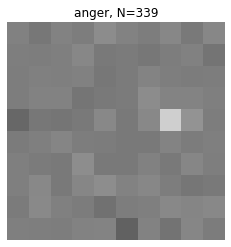

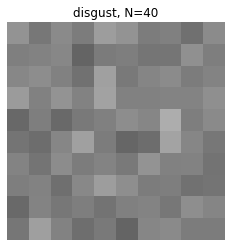

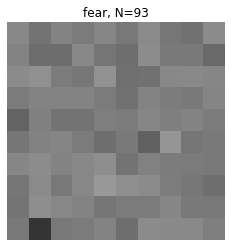

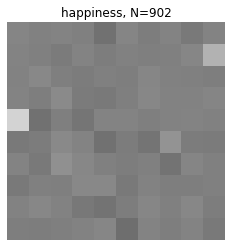

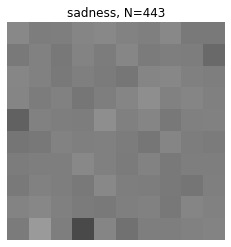

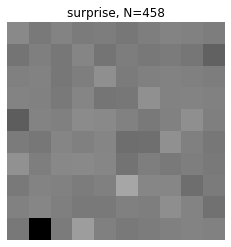

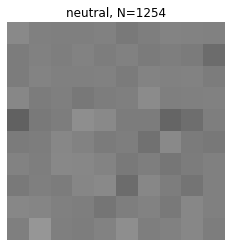

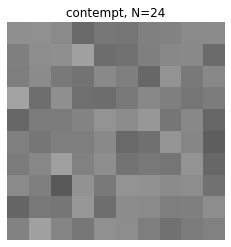

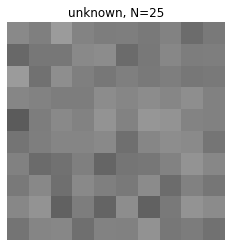

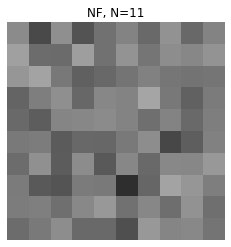

In [21]:
for e_id in np.unique(yvals_argmax):
    e_idx = yvals_argmax == e_id
    e_emb = embeddings[e_idx]
    e_emb_avg = np.mean(e_emb, axis=0).reshape((10,10))
    plt.imshow(e_emb_avg, cmap='gray', vmin=-2, vmax=2)
    plt.title(f"{labels[e_id]}, N={e_emb.shape[0]}")
    plt.axis('off')
    plt.show()

In [47]:
def edist(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

def kmeans(data, k):
    def get_centroids(data, clusters):
        centroids_new = np.zeros((k, data.shape[1]))
        for c_id in np.unique(clusters):
            c_idx = clusters == c_id
            c_data = data[c_idx]
            centroid = np.mean(c_data, axis=0)
            centroids_new[c_id] = centroid
        return centroids_new
    
    def assign_clusters(data, centroids):
        clusters_new = np.zeros(data.shape[0]).astype(int)
        for i, p in enumerate(data):
            c_dists = []
            for centroid in centroids:
                c_dists.append(edist(centroid, p))
            clusters_new[i] = np.argmin(c_dists)
        return clusters_new
    
    centroids = data[np.random.choice(np.arange(data.shape[0]), size=k)]
    clusters = np.zeros(data.shape[0])
    delta = 100
    while delta > 1e-2:
        clusters = assign_clusters(data, centroids)
        centroids_new = get_centroids(data, clusters)
        delta = np.mean([edist(c1, c2) for c1, c2 in zip(centroids, centroids_new)])
        print(delta)
        centroids = centroids_new
    return centroids, clusters
        

In [48]:
centroids, clusters = kmeans(embeddings, 7)

8.675977093728688
1.2214235084028373
0.8047959432896745
0.5557231958059804
0.44008620459778236
0.348189268898112
0.2953330712373598
0.23577627932136158
0.21289383878620494
0.16657592509657793
0.1258187654540726
0.11648333705926826
0.10604005543196518
0.10373596953642246
0.11220177365993708
0.11694921543584945
0.09783725031551493
0.07803378754613664
0.07320498082688708
0.07428078098115366
0.06907465909138773
0.05945667948042434
0.0556182062395829
0.06680336810134281
0.05746165182943313
0.05891761561831257
0.048427437460031045
0.05211514306299769
0.049296375104414605
0.04932157620149962
0.05088258374521098
0.03899812994410701
0.03556837476499474
0.03639363836706692
0.03831369800862342
0.036075066819852085
0.04034828472176853
0.050849068947029
0.04961003592595952
0.03608918360101462
0.032544234125123556
0.015640000290969066
0.012747831943544464
0.006152235390136161


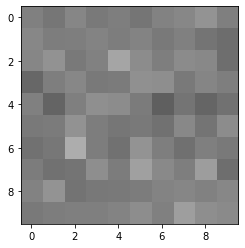

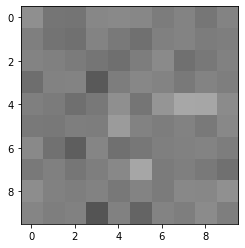

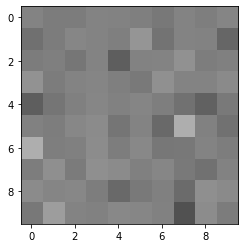

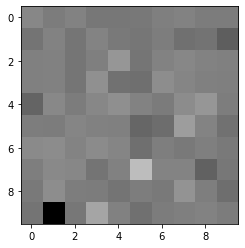

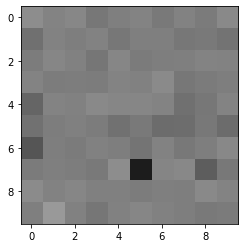

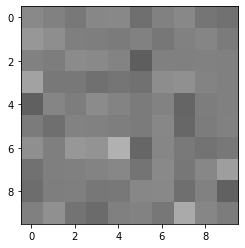

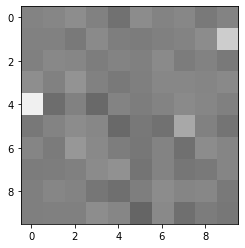

In [50]:
for centroid in centroids:
    plt.imshow(centroid.reshape((10,10)), cmap='gray', vmin=-2, vmax=2)
    plt.show()

In [79]:
def knn_test(data, data_labels, sample, ks):
    edists = [edist(sample, point) for point in data]
    k_consensus = []
    for k in ks:
        nn_idx = np.argsort(edists)[:k]
        nn_labels = data_labels[nn_idx]
        consensus = data_labels[np.argmax(np.bincount(nn_labels))]
        k_consensus.append(consensus)
    return np.array(k_consensus)

In [84]:
# LOOCV err
ks = range(1,101)
counts = np.zeros(len(ks))
for i in range(len(embeddings)-1):
    loo_idx = np.arange(len(embeddings)) != i
    k_consensus = knn_test(embeddings[loo_idx], yvals_argmax[loo_idx], embeddings[i], ks)
    truth = np.zeros(k_consensus.shape[0]) + yvals_argmax[i]
    counts += np.array(k_consensus == truth)
for k, count in zip(ks, counts):
    print(f"{k}-nn: {count / len(embeddings)}% acc")

1-nn: 0.2535525215937587% acc
2-nn: 0.27528559487322374% acc
3-nn: 0.2602396210643633% acc
4-nn: 0.26469768737809973% acc
5-nn: 0.25940373363053776% acc
6-nn: 0.2596823627751463% acc
7-nn: 0.2599609919197548% acc
8-nn: 0.2694343828364447% acc
9-nn: 0.26553357481192535% acc
10-nn: 0.2738924491501811% acc
11-nn: 0.2685984954026191% acc
12-nn: 0.27082752855948733% acc
13-nn: 0.2702702702702703% acc
14-nn: 0.26915575369183614% acc
15-nn: 0.26971301198105324% acc
16-nn: 0.27082752855948733% acc
17-nn: 0.2733351908609641% acc
18-nn: 0.27082752855948733% acc
19-nn: 0.26971301198105324% acc
20-nn: 0.27249930342713846% acc
21-nn: 0.27222067428252994% acc
22-nn: 0.2683198662580106% acc
23-nn: 0.2683198662580106% acc
24-nn: 0.2702702702702703% acc
25-nn: 0.2652549456673168% acc
26-nn: 0.26553357481192535% acc
27-nn: 0.2685984954026191% acc
28-nn: 0.26664809139035944% acc
29-nn: 0.26776260796879353% acc
30-nn: 0.2688771245472276% acc
31-nn: 0.2672053496795765% acc
32-nn: 0.2672053496795765% acc
33